In [2]:
import sys
import os
import struct
import time
import numpy as np
import gc
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import learn_params_ridge_regression, get_predictions, get_value, set_value, Torch_fwRF_voxel_block, get_r2, add_nonlinearity, get_features_in_prf, get_fmaps_sizes
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn


In [3]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [33]:
# Setting up the feature extractor w gabor filter bank

from src.torch_fwrf import get_value, set_value, _to_torch
from src.gabor_feature_extractor import Gaborizer
from src.rf_grid import linspace, logspace

class add_nonlinearity(torch.nn.Module):
    def __init__(self, _fmaps_fn, _nonlinearity):
        super(add_nonlinearity, self).__init__()
        self.fmaps_fn = _fmaps_fn
        self.nl_fn = _nonlinearity
    def forward(self, _x):
        return [self.nl_fn(_fm) for _fm in self.fmaps_fn(_x)]

# n_ori = 36
n_ori = 8
n_sf = 12
# cyc_per_stim = logspace(12)(3., 72.) # 6-92
cyc_per_stim = logspace(n_sf)(3., 72.)
# pix_per_cycle = 4.13   # this changes the actual size of filters in pixels, might help with orientation resolution?
pix_per_cycle = 4.13
# pix_per_cycle = 20

_gaborizer = Gaborizer(num_orientations=n_ori, cycles_per_stim=cyc_per_stim,
          pix_per_cycle=pix_per_cycle, cycles_per_radius=.7, 
          radii_per_filter=4, complex_cell=True, pad_type='half', 
          crop=False).to(device)

_fmaps_fn = _gaborizer
# _fmaps_fn = add_nonlinearity(_gaborizer, lambda x: torch.log(1+torch.sqrt(x)))

# pull out some relevant stuff from gaborizer object to save
sf_tuning_masks = _gaborizer.sf_tuning_masks
assert(np.all(_gaborizer.cyc_per_stim==cyc_per_stim))

ori_tuning_masks = _gaborizer.ori_tuning_masks
orients_deg = _gaborizer.orients_deg
orient_filters = _gaborizer.orient_filters    

x,y,sigma = [0,0,0.05]


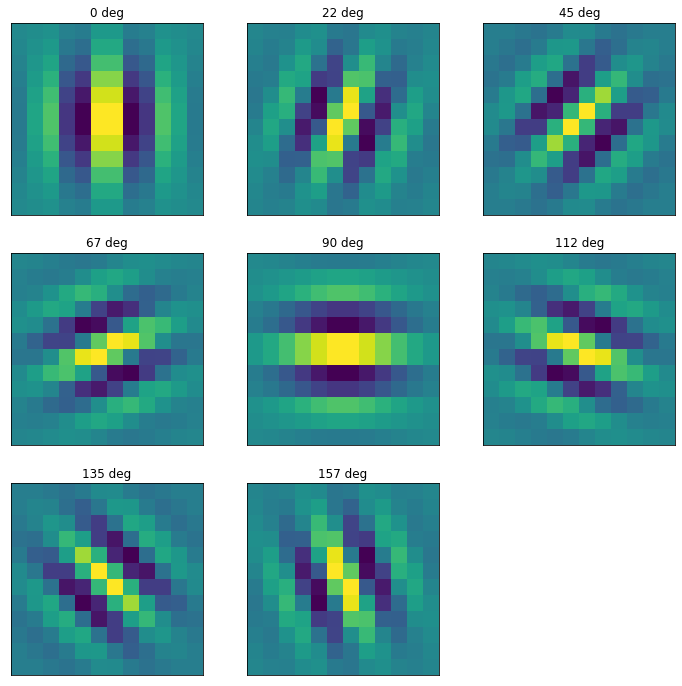

In [34]:
## Visualize the orientation filters (also double check the labels for degrees here)
# Note these are complex numbers, showing real parts only here. If you plot imaginary, will be 90 deg out of phase.

plt.figure(figsize=(12,12));
for ff in range(8):
    
    plt.subplot(3,3,ff+1)
    plt.imshow(np.real(np.squeeze(orient_filters[ff,0,:,:])))
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title('%d deg'%orients_deg[ff])

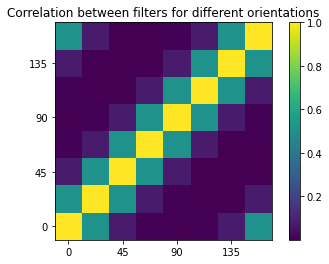

In [35]:
# Correlation structure among the filters themselves

features2use = np.reshape(np.real(orient_filters),[n_ori,np.prod(np.shape(orient_filters)[2:4])],order='F')

correlation_matrix = np.corrcoef(features2use)
plt.figure();
plt.pcolormesh(correlation_matrix)
plt.axis('square')
plt.xticks(np.arange(0,n_ori, n_ori/4)+0.5, labels= np.arange(0,179,45))
plt.yticks(np.arange(0,n_ori, n_ori/4)+0.5, labels= np.arange(0,179,45))
plt.title('Correlation between filters for different orientations')
plt.colorbar()

In [4]:
# Loading a set of actual images

nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

# Loading images to do some more testing...
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()
print ('block size:', image_data.shape, ', dtype:', image_data.dtype, ', value range:',\
    np.min(image_data[0]), np.max(image_data[0]))

from src.load_nsd import image_uncolorize_fn

images = image_uncolorize_fn(image_data[0:5000,:,:,:])
np.shape(images)

block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


(5000, 1, 227, 227)

In [9]:
np.mean(images)

0.4566951

Text(0.5, 0.98, 'sample of NSD images')

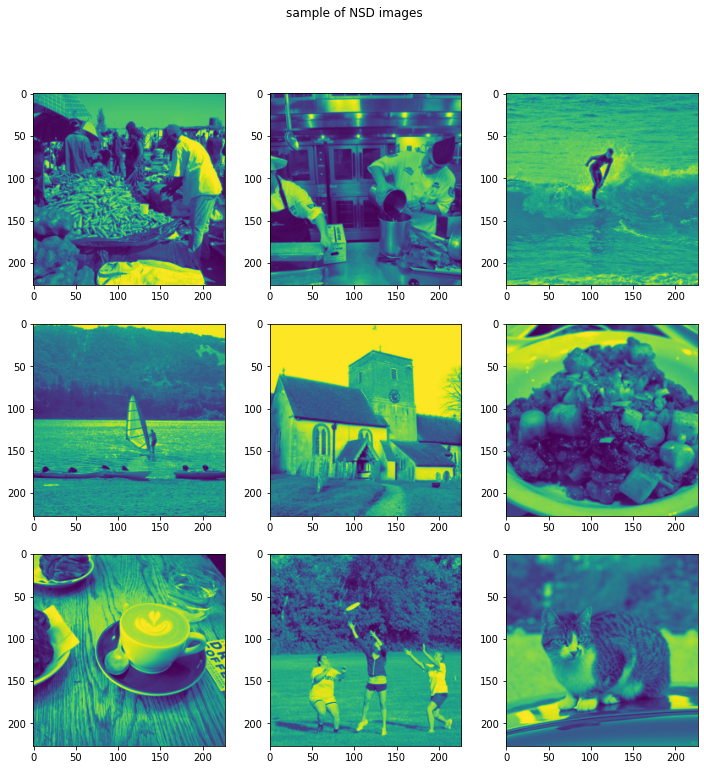

In [37]:
plt.figure(figsize=(12,12))
for ii in range(9):
    plt.subplot(3,3,ii+1);
    plt.imshow(images[ii,0,:,:])
    
plt.suptitle('sample of NSD images')

In [39]:
# Get features for the desired pRF, across all trn set image 
sample_batch_size=10
n_features, fmaps_rez = get_fmaps_sizes(_fmaps_fn, torch.tensor(images[0:sample_batch_size]).to(device), device)
features = get_features_in_prf((x,y,sigma), _fmaps_fn, images, sample_batch_size, aperture=1.0, device=device)

zscore=False
add_bias=False

if zscore:  
    features_m = np.mean(features, axis=0, keepdims=True)
    features_s = np.std(features, axis=0, keepdims=True) + 1e-6          
    features -= features_m
    features /= features_s    

if add_bias:
    features = np.concatenate([features, np.ones(shape=(len(features), 1), dtype=dtype)], axis=1)
    
print(features.shape)

(5000, 96)


Text(0, 0.5, 'images')

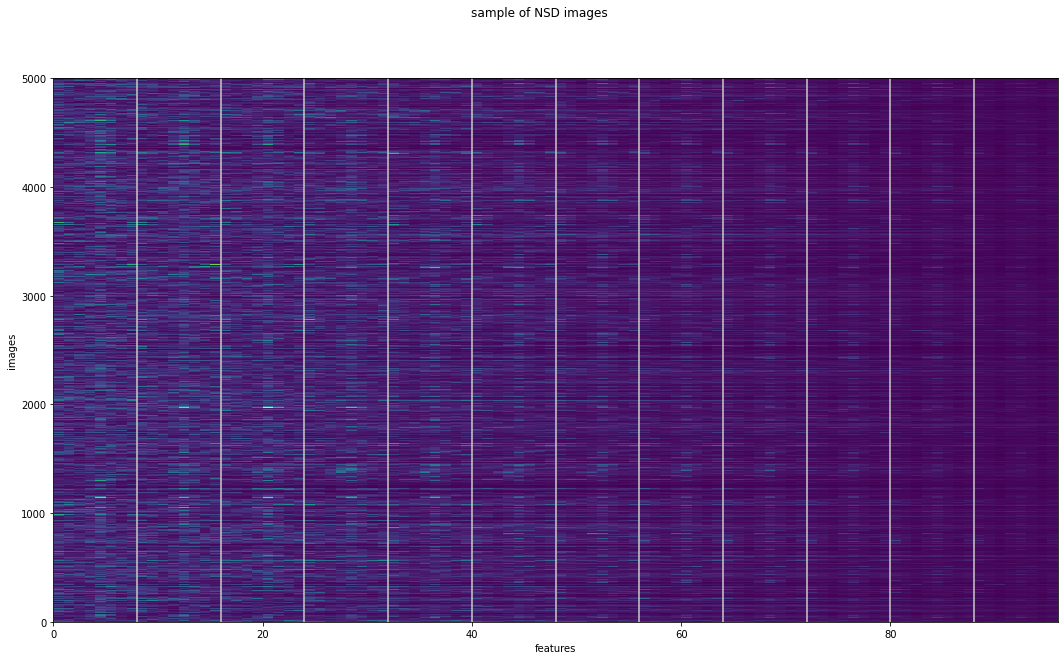

In [40]:
# visualizing ntrials x nfeatures (no z-score)

plt.figure(figsize=(18,10));
trn_features_actual = features
plt.pcolormesh(trn_features_actual)
for ii in np.arange(0,np.shape(features)[1], n_ori):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.suptitle('sample of NSD images')
plt.xlabel('features')
plt.ylabel('images')

Text(0.5, 1.0, 'covariance of raw feature values')

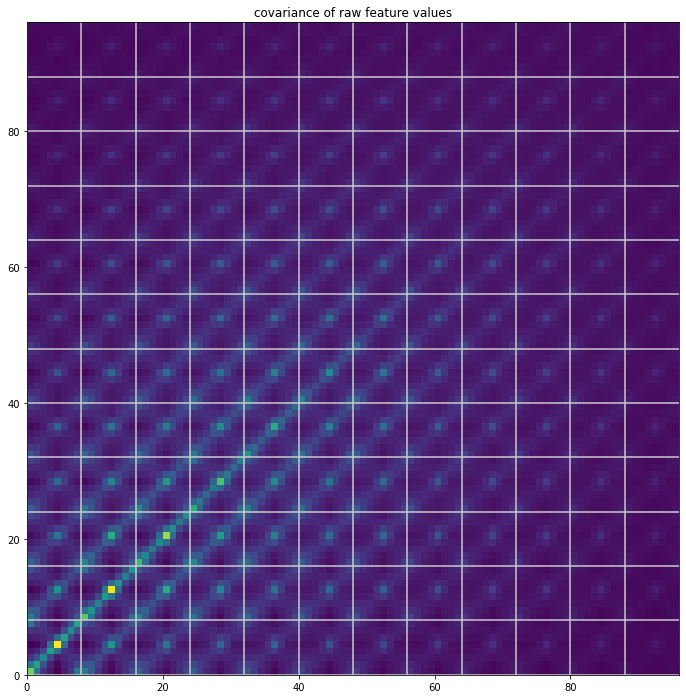

In [41]:
# visualizing covariance among features in the training set data - before and after z-scoring
# all features are nori*nsf = 432 total
import scipy
plt.figure(figsize=(20,12));

trn_features_actual = features
covariance_trn = np.cov(np.transpose(trn_features_actual))
plt.pcolormesh(covariance_trn)
for ii in np.arange(0,np.shape(features)[1], n_ori):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    plt.axhline(ii,color=[0.8, 0.8, 0.8])
# plt.colorbar()
plt.axis('square')
plt.title('covariance of raw feature values')


In [70]:
orients_deg

array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])

Text(0.5, 0.98, 'sample of NSD images\ncovariance of raw feature values')

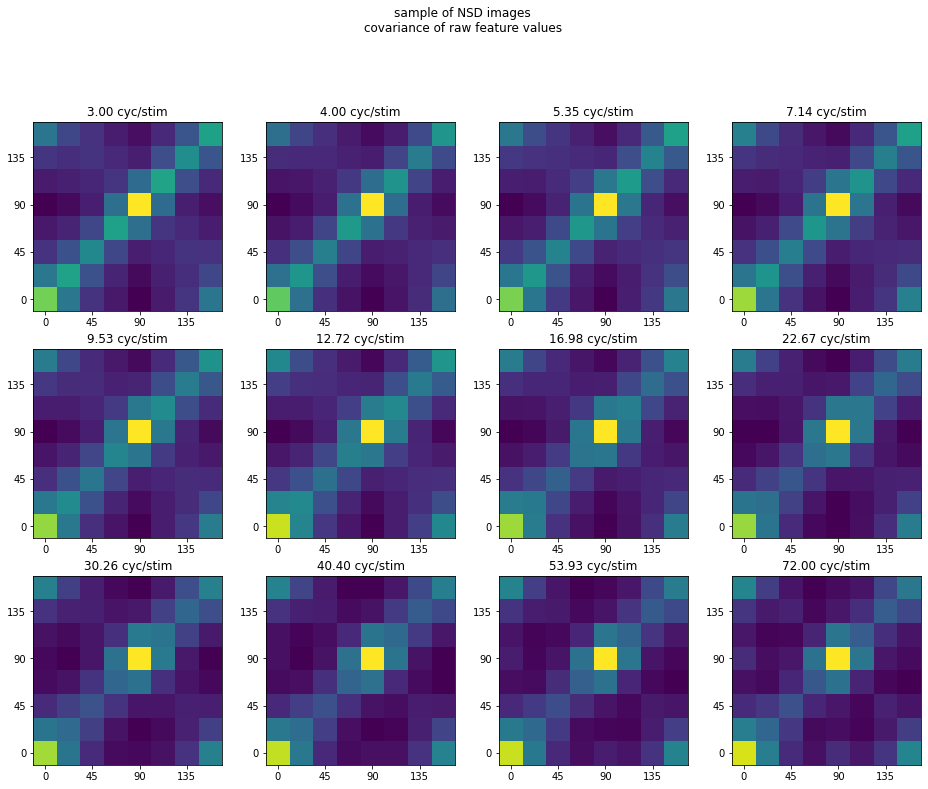

In [43]:
# visualizing just one SF at a time...

# trn_features_actual = scipy.stats.zscore(features)
trn_features_actual = features
plt.figure(figsize=(16,16));
# plotting one sf at a time to see within-sf orientation covariance...
for sf2plot in range(n_sf):

    covariance_trn = np.cov(np.transpose(trn_features_actual[:,sf_tuning_masks[sf2plot]]))
    plt.subplot(4,4,sf2plot+1)
    plt.pcolormesh(covariance_trn)
#     plt.colorbar()
    plt.axis('square')
    plt.xticks(np.arange(0,n_ori, n_ori/4)+0.5,labels=np.arange(0,179,45))
    plt.yticks(np.arange(0,n_ori, n_ori/4)+0.5,labels=np.arange(0,179,45))
    plt.title('%.2f cyc/stim'%(cyc_per_stim[sf2plot]))
    
plt.suptitle('sample of NSD images\ncovariance of raw feature values')

In [37]:
# Using this custom code that will let us change aspect ratio...this should make filters overlap less 
import gfb_utils as g

n_ori = 8
n_sf = 12
# cyc_per_stim = logspace(12)(3., 72.) # 6-92
cyc_per_stim = logspace(n_sf)(3., 72.)
# First define the feature bank itself
freqs_cpp = cyc_per_stim/227
# freqs_cpp = np.round(np.logspace(np.log10(0.02), np.log10(0.25), 3),2)
orient_step = 180/n_ori
orients_deg = np.arange(0,181-orient_step, orient_step)
spat_freq_bw = 1
spat_aspect_ratio = 0.5
n_sd_out = 2.5

process_at_size = [227,227]

# This is the code i wrote to do gabor filtering, without any downsampling of images
# i.e. filter at their original resolutions
bank = g.filter_bank(orients_deg, freqs_cpp, spat_freq_bw, spat_aspect_ratio, n_sd_out, image_size = process_at_size)


In [38]:
## Run images throigh this model

n_images= 100
sample_batch_size=2

t_start = time.time()
t = time.time()
gfe = g.gabor_feature_extractor_spat(bank, device=device)
elapsed = time.time() - t
print('took %.2f s to make filters'%elapsed)

maps_spat = g.get_feature_maps_batches(gfe, images[0:n_images], sample_batch_size, device)

print(np.shape(maps_spat))

elapsed_total = time.time() - t_start
print('total time is %.2f s'%elapsed_total)

took 0.60 s to make filters
(100, 227, 227, 96)
total time is 90.34 s


In [39]:
x,y,sigma = [0,0,0.05]
n_features = n_ori*n_sf
n_pix_new = np.shape(maps_spat)[1]
prf_new = pnu.make_gaussian_mass(x, y, sigma, n_pix_new, size=1.0, dtype=fpX)[2]
features_spat = [np.tensordot(maps_spat[:,:,:,ff], prf_new, axes=[[1,2], [0,1]]) for ff in range(0,n_features)]
cov_spat = np.cov(features_spat)

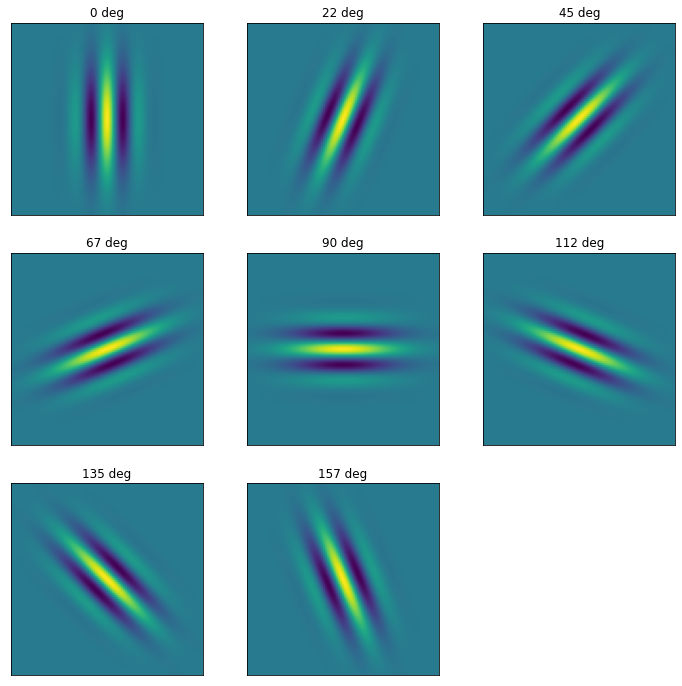

In [40]:
## Visualize the orientation filters (these are different sizes for different SFs)
sf=5
orient_filters = gfe.filters_spat[sf].cpu().detach().numpy()

plt.figure(figsize=(12,12));
for ff in range(8):
    
    plt.subplot(3,3,ff+1)
    plt.imshow(np.real(np.squeeze(orient_filters[ff,:,:])))
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title('%d deg'%orients_deg[ff])

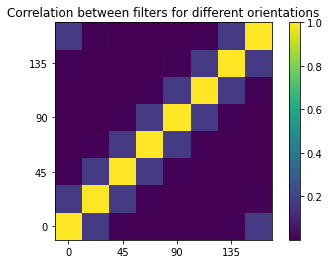

In [32]:
# Correlation structure among the filters themselves

features2use = np.reshape(np.real(orient_filters),[n_ori,np.prod(np.shape(orient_filters)[1:3])],order='F')

correlation_matrix = np.corrcoef(features2use)
plt.figure();
plt.pcolormesh(correlation_matrix)
plt.axis('square')
plt.xticks(np.arange(0,n_ori, n_ori/4)+0.5, labels= np.arange(0,179,45))
plt.yticks(np.arange(0,n_ori, n_ori/4)+0.5, labels= np.arange(0,179,45))
plt.title('Correlation between filters for different orientations')
plt.colorbar()

Text(0, 0.5, 'images')

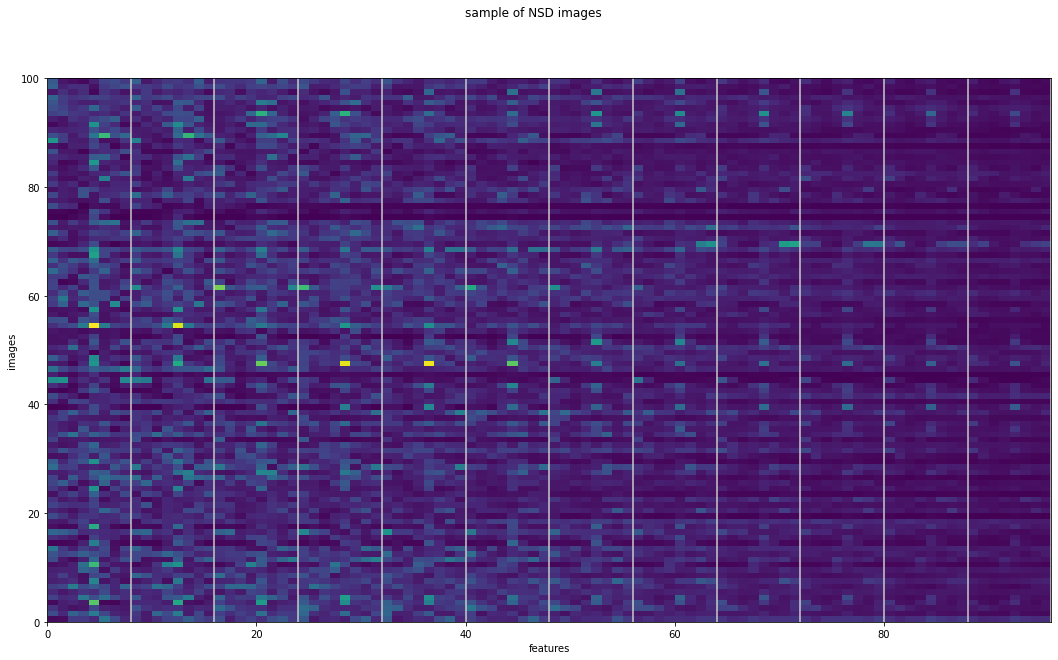

In [33]:
# visualizing ntrials x nfeatures (no z-score)

plt.figure(figsize=(18,10));
plt.pcolormesh(np.transpose(features_spat))
for ii in np.arange(0,np.shape(features_spat)[1], n_ori):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.suptitle('sample of NSD images')
plt.xlabel('features')
plt.ylabel('images')

Text(0.5, 1.0, 'covariance of raw feature values')

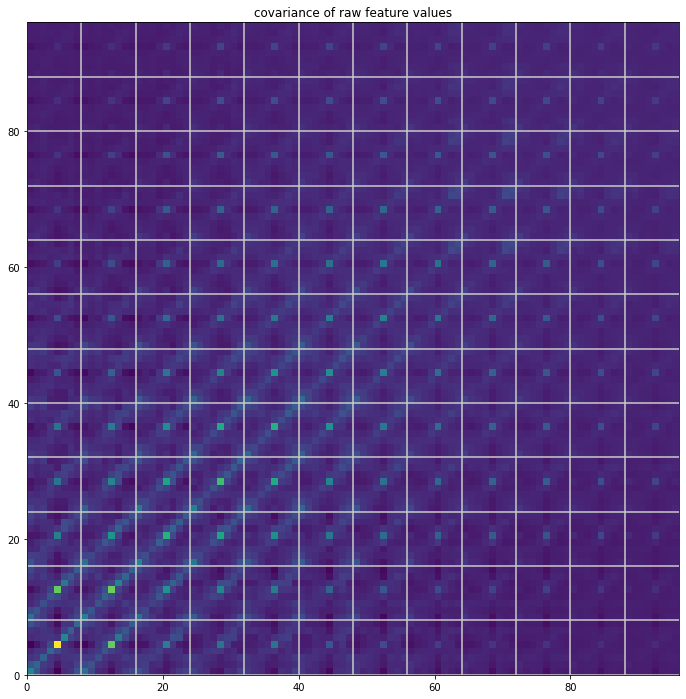

In [34]:
# visualizing covariance among features in the training set data 
# all features are nori*nsf 
import scipy
plt.figure(figsize=(20,12));

plt.pcolormesh(cov_spat)
for ii in np.arange(0,np.shape(cov_spat)[1], n_ori):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
    plt.axhline(ii,color=[0.8, 0.8, 0.8])
# plt.colorbar()
plt.axis('square')
plt.title('covariance of raw feature values')
